In [32]:
%matplotlib inline
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler


from sklearn.decomposition import PCA
from scipy.stats import zscore

# Read the dataset

mpg_df = pd.read_csv("d:\gli\dse\data\car-mpg.csv")  # download data from UCI and added column header


# drop the car name column as it is useless for the model
car_name = mpg_df['car_name']
mpg_df = mpg_df.drop('car_name', axis=1)
mpg_df.head()

,mpg,cyl,disp,hp,wt,acc,yr,origin,car_type
0,18.0,8,307.0,130,3504,12.0,70,1,0
1,15.0,8,350.0,165,3693,11.5,70,1,0
2,18.0,8,318.0,150,3436,11.0,70,1,0
3,16.0,8,304.0,150,3433,12.0,70,1,0
4,17.0,8,302.0,140,3449,10.5,70,1,0


In [33]:
# horsepower is an object type though it is supposed to be numeric. Check if all the rows in this column are digits 

temp = pd.DataFrame(mpg_df.hp.str.isdigit())  # if the string is made of digits store True else False  in the hp column 
temp[temp['hp'] == False]   # from temp take only those rows where hp has false

# On inspecting records number 32, 126 etc, we find "?" in the columns. Replace them with "nan"
#Replace them with nan and remove the records from the data frame that have "nan"

mpg_df = mpg_df.replace('?', np.nan)
mpg_df = mpg_df.apply(lambda x: x.fillna(x.median()),axis=0)


# converting the hp column from object / string type to float
mpg_df['hp'] = mpg_df['hp'].astype('float64')  


In [34]:
X = mpg_df[mpg_df.columns[1:-1]]   # The last column index is -1 and that is not considered in the range
y = mpg_df["mpg"]

In [35]:
X = X.drop(['acc' , 'cyl' ] , axis=1)

In [36]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)


print(X_train.shape)
print(X_test.shape)
print(y_test.shape)

(278, 5)
(120, 5)
(120,)


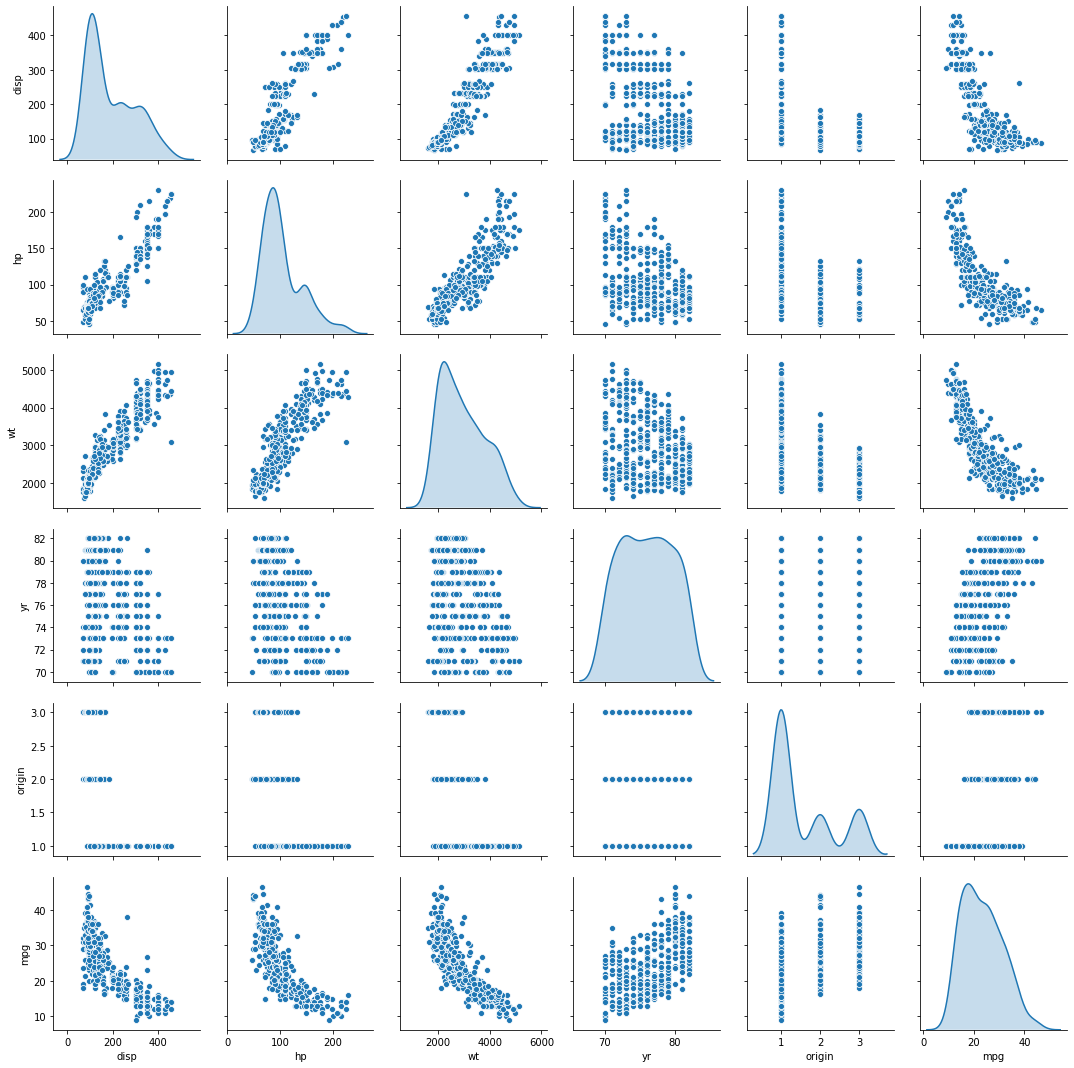

In [37]:
#Visually inspect the covariance between independent dimensions and between mpg and independent dimensions

#sns.pairplot(mpg_df, diag_kind='kde') 
sns.pairplot(X.join(y), diag_kind='kde') 

# PCA starts from here

### Step 1 - centre the data in independent variables

In [38]:
sc = StandardScaler()
X_train_std =  sc.fit_transform(X_train)   
 
train_cov_matrix = np.cov(X_train_std.T)

print('Covariance Matrix \n%s', train_cov_matrix)  # The quantities in the matrix should reflect the observations in pairplot

Covariance Matrix 
%s [[ 1.00361011  0.89032763  0.93969096 -0.35855376 -0.59647546]
 [ 0.89032763  1.00361011  0.87229407 -0.38096256 -0.42185084]
 [ 0.93969096  0.87229407  1.00361011 -0.29284492 -0.56612671]
 [-0.35855376 -0.38096256 -0.29284492  1.00361011  0.15624642]
 [-0.59647546 -0.42185084 -0.56612671  0.15624642  1.00361011]]


### Step2 - Matrix decomposition 

In [39]:
eigenvalues, eigenvectors = np.linalg.eig(train_cov_matrix)
print('Eigen Vectors \n%s', eigenvectors)
print('\n Eigen Values \n%s', eigenvalues)

Eigen Vectors 
%s [[ 0.53020298  0.07219395  0.14609841  0.7869433  -0.27027457]
 [ 0.50131942 -0.0571179   0.38664016 -0.14381717  0.75844736]
 [ 0.5190216   0.13034894  0.22049491 -0.59434951 -0.55835148]
 [-0.25179008  0.89962747  0.34780502  0.04500555  0.06540899]
 [-0.36712665 -0.40645436  0.81214426  0.06899294 -0.18887708]]

 Eigen Values 
%s [3.34860026 0.88600066 0.60868845 0.05838473 0.11637645]


### Step 3 - Sort the Eigen values in descending order (The order may not be descending by default as in the example above)

In [40]:
# Make a set of (eigenvalue, eigenvector) pairs
train_eig_pairs = [(eigenvalues[index], eigenvectors[index, :]) for index in range(len(eigenvalues))]

# Sort the (eigenvalue, eigenvector) pairs from highest to lowest with respect to eigenvalue
train_eig_pairs.sort(reverse = True)

train_eig_pairs

[(3.348600260712443,
  array([ 0.53020298,  0.07219395,  0.14609841,  0.7869433 , -0.27027457])),
 (0.8860006580785111,
  array([ 0.50131942, -0.0571179 ,  0.38664016, -0.14381717,  0.75844736])),
 (0.6086884458941577,
  array([ 0.5190216 ,  0.13034894,  0.22049491, -0.59434951, -0.55835148])),
 (0.11637644653266542,
  array([-0.36712665, -0.40645436,  0.81214426,  0.06899294, -0.18887708])),
 (0.058384730298464124,
  array([-0.25179008,  0.89962747,  0.34780502,  0.04500555,  0.06540899]))]

### Step 4 - Separate the sorted Eigen values  and Eigen vectors for subsequent use in graphing

In [41]:
train_eigvalues_sorted = [train_eig_pairs[index][0] for index in range(len(eigenvalues))]
train_eigvectors_sorted = [train_eig_pairs[index][1] for index in range(len(eigenvalues))]

# Let's confirm our sorting worked, print out eigenvalues
print('Eigenvalues in descending order: \n%s' %train_eigvalues_sorted)

Eigenvalues in descending order: 
[3.348600260712443, 0.8860006580785111, 0.6086884458941577, 0.11637644653266542, 0.058384730298464124]


### Step 5 - convert the Eigen values to %age of total covariance explained and create a cumulative sum 

In [42]:
tot = sum(eigenvalues) # Sum up all the Eigen values to reflect the total covariance captured from original feature space


#%age of total covariance explained = [(i / tot) for i in sorted(train_eigvalues_sorted, reverse=True)]  
# array of variance explained by each Eigen vector will be generated

var_explained = [(i / tot) for i in train_eigvalues_sorted] 




# an array of cumulative covariance captured by the Eigen vectors together

cum_var_exp = np.cumsum(var_explained)  

In [43]:
print(var_explained)

[0.6673109872067248, 0.17656272107032214, 0.12129978382207325, 0.023191565244279386, 0.011634942656600413]


In [44]:
print(cum_var_exp)

[0.66731099 0.84387371 0.96517349 0.98836506 1.        ]


### Step 6 -  Plot the % covariance captured by each Eigen vector and the cumulative covariance 

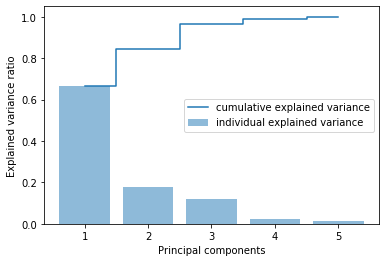

In [46]:
plt.bar(range(1,6), var_explained, alpha=0.5, align='center', label='individual explained variance')
plt.step(range(1,6),cum_var_exp, where= 'mid', label='cumulative explained variance')
plt.ylabel('Explained variance ratio')
plt.xlabel('Principal components')
plt.legend(loc = 'best')
plt.show()

### Step 7 - Drop principal components that capture insignificant amount of the covariance compared to others and project the original data into the reduced PC dimension space

In [54]:
# P_reduce represents reduced mathematical space....

P_reduce = np.array(train_eigvectors_sorted[0:4])   # In this case using all the three PC dimensions- not reducing  actually

X_std_3D = np.dot(X_train_std,P_reduce.T)   # projecting original data into principal component dimensions

Proj_train_data_df = pd.DataFrame(X_std_3D)  # converting array to dataframe for pairplot


In [55]:
Proj_train_data_df.head()

,0,1,2,3
0,0.645711,-1.437105,-1.205185,0.267535
1,-1.663569,-0.146702,-0.514496,0.027048
2,-1.107901,0.124989,-0.191887,-0.078095
3,0.265948,1.015291,2.771902,-0.454003
4,-0.132302,0.275878,-2.713805,-0.429279


### Step 8 - Build the linear regression model on the training data from PC dimension feature space

In [56]:
# Import Linear Regression machine learning library
from sklearn.linear_model import LinearRegression

regression_model = LinearRegression()
regression_model.fit(Proj_train_data_df, y_train)

regression_model.coef_

array([ 0.72710033, -2.6856408 , -3.78606814, -3.49496934])

In [57]:
regression_model.intercept_

23.600719424460433

In [58]:
regression_model.score(Proj_train_data_df, y_train)

0.7880680307897932

### Step 9 - Test the model on projected test data i.e. test data mapped to PC dimension feature space

In [59]:
X_test_std =  sc.fit_transform(X_test) # Standardize the test data using Zscores -  centring the data


X_test_std_3D = np.dot(X_test_std,P_reduce.T)   # projecting original data into principal component dimensions

Proj_test_data_df = pd.DataFrame(X_test_std_3D)  # converting array to dataframe for pairplot

In [60]:
Proj_test_data_df.shape

(120, 4)

In [61]:
regression_model.score(Proj_test_data_df, y_test)

0.846673546177903

## Visual Analysis Pitfall

### Step 10 - Visually analyise relation between target (mpg) and the principal components. 

d:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in greater
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.
d:\Anaconda3\lib\site-packages\statsmodels\nonparametric\kde.py:447: RuntimeWarning: invalid value encountered in less
  X = X[np.logical_and(X > clip[0], X < clip[1])] # won't work for two columns.


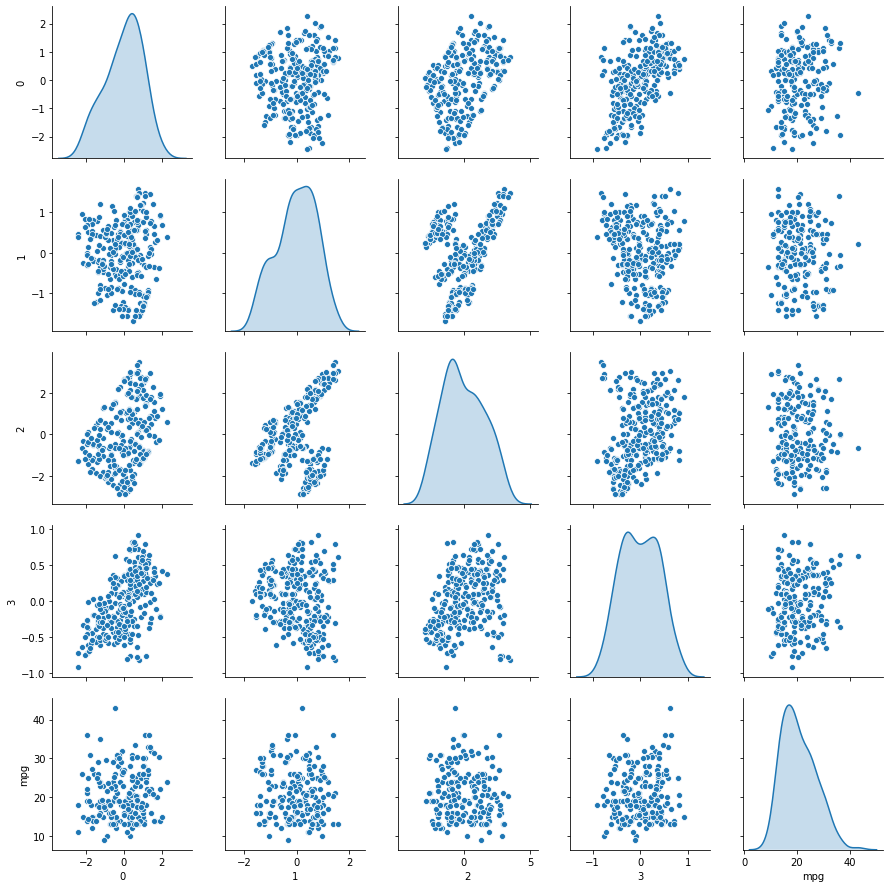

In [62]:
#Let us check it visually

Proj_train_data_df = Proj_train_data_df.join(y_train)

sns.pairplot(Proj_train_data_df, diag_kind='kde') 

# Note

1. Strong collinearity between original feature is almost gone as is evident from the scatter plots. There are some weak collinearity still but that is likely due to the curvilinear distributions in orignal space and could also be noise


2. The scatter plot between "Mpg" and principal components show very poor collinearity!!! This is surprising as the scores in training and testing were 60% and 70%... Not good but not possible with this kind of scatter 


3. This inconsistency is because of the unwanted changes that happend when we transformed the data using standard scaler


4.	When a data is randomly split into training and testing datasets i.e. (X_train, y-train), (X_test, y_test) and the X_train and X_test are transformed using standard scaler or any other tool, the internal index of the records in both the new datasets (X_train_std, X_test_std) change. Though the records physically remain in the same order and their one-to-one correspondence with the y_train and y_test remain intact, the indexes don’t match!


5.	When the join is done between the X_train_std data and y_train for e.g. Proj_train_data_df and y_train in the code, the join is done using index leading to incorrect joins! 


6.	In some records it will introduce Nan in the y_train as the y_train does not have the index value which Proj_train_data_df has!. This incorrect join leads to incorrect pairplot between the target and independent variables


7. To check this out, list out the records in X_train , Y_train (their indexes will be same). Next list out the X_train_std. The indices will not match! 


8. Pairplot selects records by index from X_train, Y_train to do the plot and that is a mistake because the X_train index has changed! It will pick up incorrect combination of train and y to do the plot! That is what is happening above



In [63]:
X_train

,disp,hp,wt,yr,origin
350,105.0,63.0,2215,81,1
59,97.0,54.0,2254,72,2
120,121.0,112.0,2868,73,2
12,400.0,150.0,3761,70,1
349,91.0,68.0,1985,81,3
...,...,...,...,...,...
393,140.0,86.0,2790,82,1
255,140.0,88.0,2720,78,1
72,304.0,150.0,3892,72,1
235,97.0,75.0,2265,77,3


In [64]:
y_train

350    34.7
59     23.0
120    19.0
12     15.0
349    34.1
       ... 
393    27.0
255    25.1
72     15.0
235    26.0
37     18.0
Name: mpg, Length: 278, dtype: float64

In [65]:
Proj_train_data_df   

,0,1,2,3,mpg
0,0.645711,-1.437105,-1.205185,0.267535,18.0
1,-1.663569,-0.146702,-0.514496,0.027048,15.0
2,-1.107901,0.124989,-0.191887,-0.078095,18.0
3,0.265948,1.015291,2.771902,-0.454003,16.0
4,-0.132302,0.275878,-2.713805,-0.429279,NaN
...,...,...,...,...,...
273,1.184430,-1.076011,-0.958391,0.464324,23.9
274,0.323009,-0.955184,-0.325363,0.300552,NaN
275,0.216757,0.526028,1.996005,0.054504,17.0
276,-0.892406,0.578792,-1.941537,-0.332175,21.6


### Rectification - To rectify this situation, copy the index of X_train into X_train_std

In [66]:
Proj_train_data_df.pop("mpg")  #remove mpg column
Proj_train_data_df.index = X_train.index  # (Restoring the original index into the project data)
Proj_train_data_df = Proj_train_data_df.join(y_train)  # rejoining after resetting the index

In [67]:
Proj_train_data_df  # observe the index has been restored and there are no visible "NaN" in the target column

,0,1,2,3,mpg
350,0.645711,-1.437105,-1.205185,0.267535,34.7
59,-1.663569,-0.146702,-0.514496,0.027048,23.0
120,-1.107901,0.124989,-0.191887,-0.078095,19.0
12,0.265948,1.015291,2.771902,-0.454003,15.0
349,-0.132302,0.275878,-2.713805,-0.429279,34.1
...,...,...,...,...,...
393,1.184430,-1.076011,-0.958391,0.464324,27.0
255,0.323009,-0.955184,-0.325363,0.300552,25.1
72,0.216757,0.526028,1.996005,0.054504,15.0
235,-0.892406,0.578792,-1.941537,-0.332175,26.0


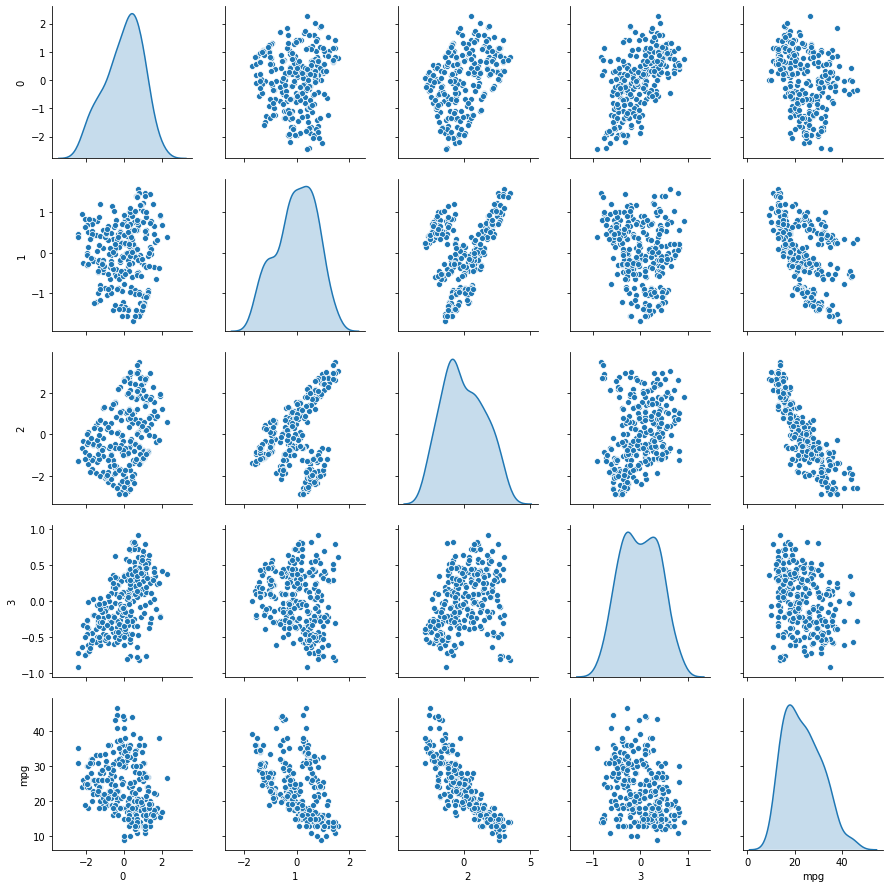

In [68]:
sns.pairplot(Proj_train_data_df, diag_kind = "kde")